In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

import yfinance as yf
import ta as ta
import empyrical as ep

import statsmodels.formula.api as smf
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()

import warnings
warnings.filterwarnings("ignore")

### Get List of NASDAQ-100 Companies and Tickers

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')[3]

### Only Keep Class A for Companies with Multiple Classes

In [44]:
multiclass = table[table.Company.str.contains("Class")]
drop_index = multiclass[multiclass.Company.str[-9:] != "(Class A)"].index
table.drop(drop_index,axis=0,inplace=True)
table.to_csv("Data/Tickers_11_24_2020.csv")

### Saved Tickerlist from November 19, 2020

In [4]:
tickerlist = list(pd.read_csv("Tickers_11_24_2020.csv",index_col=0).Ticker)

### Download Data Using Yahoo Finance

In [5]:
start = "2010-01-01"

def download_data(tickerlist,start_date):
    data = yf.download(tickerlist,start=start_date,group_by="ticker",auto_adjust = True)
    data.to_csv("Data/NASDAQ100_data.csv")
    
# download_data(tickerlist,start)

In [6]:
def read_data_csv(filename):
    """
    CSV file saved with multi-index columns (layer 1: ticker, layer 2: [Open, High, Low, Close, Adj Close, Volume])
    """    
    read_data = pd.read_csv(filename,header=[0, 1],index_col=0)
    read_data.index = pd.DatetimeIndex(read_data.index)
    return read_data

In [7]:
all_data = read_data_csv("Data/NASDAQ100_data.csv")

### Find First Date for Each Ticker; Remove Tickers that Do Not Start in 2010 - 01 - 04

In [8]:
first_dates = []
for ticker in tickerlist:
    first_dates.append(all_data[(ticker,"Close")].dropna().index[0])
first_dates = pd.DataFrame(first_dates,index=tickerlist,columns=["FirstDate"])
tickerlist = list(first_dates[first_dates.FirstDate=="2010-01-04"].index)

In [9]:
def get_data(ticker,all_data=all_data):
    temp = all_data[ticker].copy()
    return temp

get_data("AAPL")

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,6.522158,6.554855,6.490071,6.539882,493729600.0
2010-01-05,6.557910,6.588163,6.516656,6.551187,601904800.0
2010-01-06,6.551189,6.577164,6.440261,6.446983,552160000.0
2010-01-07,6.470819,6.478459,6.388311,6.435065,477131200.0
2010-01-08,6.426508,6.478458,6.388615,6.477847,447610800.0
...,...,...,...,...,...
2020-11-18,118.610001,119.820000,118.000000,118.029999,76322100.0
2020-11-19,117.589996,119.059998,116.809998,118.639999,74113000.0
2020-11-20,118.639999,118.769997,117.290001,117.339996,73391400.0


## Factor Calculation and Selection

https://technical-analysis-library-in-python.readthedocs.io/en/latest/

In [10]:
def calc_all_factors(df):
    data = df.copy().dropna()
    Close = data["Close"]
    High = data["High"]
    Low = data["Low"]
    Open = data["Open"]
    Volume = data["Volume"]

    df = pd.DataFrame(index=data.index)
    # Momentum Indicators
    df["AO"] = ta.momentum.awesome_oscillator(High, Low, window1=5, window2=34)
    df["KAMA"] = ta.momentum.kama(Close,10,2,30)
    df["PPO"] = ta.momentum.ppo_signal(Close,26,12,9)
    df["RSI"] = ta.momentum.rsi(Close,14)
    df["SO"] = ta.momentum.stoch_signal(Close,High,Low,14,3)

    # Volume Indicators
    df["ADI"] = ta.volume.acc_dist_index(High, Low, Close, Volume)
    df["CMF"] = ta.volume.chaikin_money_flow(High,Low,Close,Volume,14)
    df["EoM"] = ta.volume.ease_of_movement(High, Low, Volume,14)
    df["FI"] = ta.volume.force_index(Close, Volume, 13)
    df["OBV"] = ta.volume.on_balance_volume(Close,Volume)

    # Volatility Indicators
    df["UI"] = ta.volatility.ulcer_index(Close,14) # Ulcer Index
    df["ATR"] = ta.volatility.average_true_range(High,Low,Close,14) # Average True Range
    df["BB"] = ta.volatility.bollinger_pband(Close,20,2) # Bollinger Band Percentage Band
    df["DC"] = ta.volatility.donchian_channel_pband(High,Low,Close,10,0) # Donchian Channel Percentage Band
    df["KC"] = ta.volatility.keltner_channel_pband(High,Low,Close,20,10)


    # Trend Indicator
    df["ADX"] = ta.trend.adx(High,Low,Close,14)
    df["CCI"] = ta.trend.cci(High, Low, Close,20,0.015)
    df["DPO"] = ta.trend.dpo(Close,20)
    df["MACD"] = ta.trend.macd_diff(Close,12,26,9) # MACD - MACD Signal
    df["MI"] = ta.trend.mass_index(High, Low,9,25)
    df["ForwardReturns"] = (Close.pct_change().shift(-1))
    df["Close"] = Close
    df.dropna(inplace=True)
    df.iloc[:,:20] = mm_scaler.fit_transform(df.iloc[:,:20])
    return df

In [11]:
def IndicatorVsPricePlot(df,indicator,plot_dates):
    sns.set()
    fig,ax = plt.subplots(facecolor = "white",figsize=(15,10))
    ax = plt.subplot2grid((12,10), (0,0), rowspan=10, colspan=10)
    ax.plot(df[plot_dates[0]:plot_dates[1]]["Close"],color="black")
    ax.set_xlabel("Date",fontsize=14)
    ax.set_ylabel("Close Price",color="black",fontsize=14)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.grid(False)
    ax2 = ax.twinx()
    ax2.plot(df[plot_dates[0]:plot_dates[1]][indicator],color="red")
    ax2.set_ylabel(indicator,color="red",fontsize=14)
    ax2.tick_params(axis='y',labelsize=14)
    ax2.grid(False)
#     plt.title("Average True Range",fontsize=20)

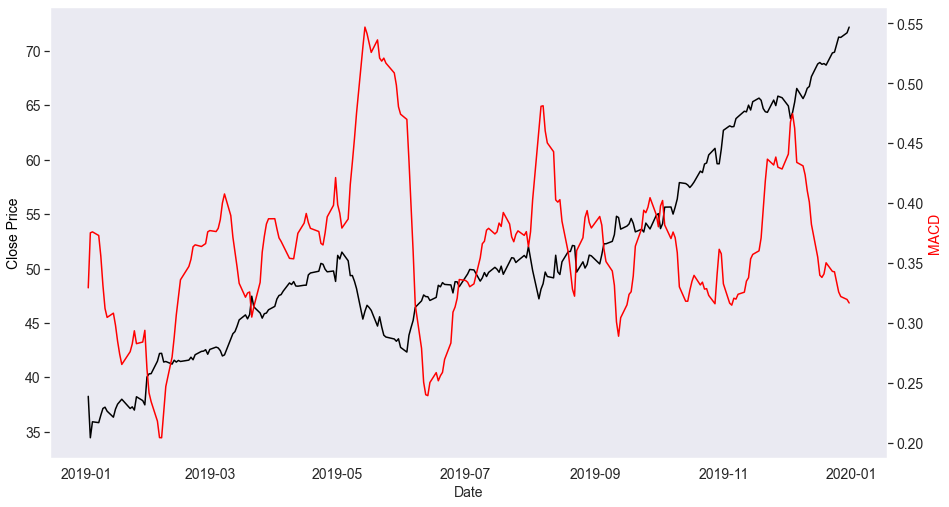

In [12]:
df = calc_all_factors(get_data("AAPL"))
plot_dates = ("2019-01-01","2020-01-01")
IndicatorVsPricePlot(df,"MACD",plot_dates)

### Calculate All Factors for All Stocks for Initial Factor Analysis and Selection

In [13]:
data = {}
for ticker in tickerlist:
    temp = calc_all_factors(get_data(ticker))
    data[ticker] = temp["2010":"2015"]

all_factors = data["AAPL"].columns[:20]

In [14]:
tickerlist = []
for i in data.keys():
    if data[i].shape==data["AAPL"].shape:
        tickerlist.append(i)
pd.DataFrame(tickerlist).to_csv("Data/AllTickers.csv")

In [15]:
def combine_factors(factors,data,tickerlist):
    n = len(tickerlist)
    f = len(factors)
    t = len(data[tickerlist[0]])
    X = np.zeros((t*n,f))
    Y = np.zeros((t*n,1))
    for i in range(n):
        X[i*t:i*t+t,:] = data[tickerlist[i]][factors].values
        Y[i*t:i*t+t,:] = data[tickerlist[i]][["ForwardReturns"]].values
    X = pd.DataFrame(X,columns=factors)
    X["ForwardReturns"] = Y
    return X

def get_all_combinations(fa):
    combos = []
    for i in range(0,5):
        for j in range(5,10):
            for k in range(10,15):
                for l in range(15,20):
                    combos.append([fa[i],fa[j],fa[k],fa[l]])
    return combos
all_combos = get_all_combinations(all_factors)

In [16]:
df_fac = combine_factors(all_factors,data,tickerlist)
corr = df_fac.corr()
corr.to_csv("Data/correlation.csv")

In [17]:
def factorComboAnalysis(all_combos,corr):
    temp = []
    for combo in all_combos:
        interFacCorr = []
        facRetCorr = [] 
        for i in range(4):
            facRetCorr.append(corr.loc[combo[i],"ForwardReturns"])
            for j in range(i+1,4):
                interFacCorr.append(corr.loc[combo[i],combo[j]])
        aveRet = np.mean(np.abs(facRetCorr))
        aveFac = np.mean(np.abs(interFacCorr))
        maxFac = np.max(np.abs(interFacCorr))
        temp.append([combo,aveFac,maxFac,aveRet])

    analysis = pd.DataFrame(temp,columns=["Combo","AverageInterFactorCorr","MaxInterFactorCorr","AverageFactorReturnCorr"])
    return analysis

In [18]:
analysis1 = factorComboAnalysis(all_combos,corr)
desc1 = analysis1.iloc[:,1:].describe()
desc1.loc[["mean","min","max"],:]

,AverageInterFactorCorr,MaxInterFactorCorr,AverageFactorReturnCorr
mean,0.207175,0.560857,0.016541
min,0.032314,0.051359,0.006218
max,0.694061,0.925030,0.026345


In [19]:
lim1 = 0.05
lim2 = 0.15
analysis1[(analysis1.AverageInterFactorCorr<lim1) & 
          (analysis1.MaxInterFactorCorr<lim2)].sort_values("AverageFactorReturnCorr",ascending=False).head(30)

,Combo,AverageInterFactorCorr,MaxInterFactorCorr,AverageFactorReturnCorr
219,"[KAMA, FI, DC, MI]",0.035101,0.098727,0.015066
214,"[KAMA, FI, BB, MI]",0.049149,0.142030,0.014282
194,"[KAMA, EoM, DC, MI]",0.035353,0.063842,0.014046
215,"[KAMA, FI, DC, ADX]",0.036233,0.098727,0.013753
189,"[KAMA, EoM, BB, MI]",0.044188,0.064521,0.013262
210,"[KAMA, FI, BB, ADX]",0.046973,0.142030,0.012968
199,"[KAMA, EoM, KC, MI]",0.047555,0.072192,0.012960
190,"[KAMA, EoM, DC, ADX]",0.032314,0.051359,0.012733
185,"[KAMA, EoM, BB, ADX]",0.037843,0.074041,0.011949
175,"[KAMA, EoM, UI, ADX]",0.038385,0.051900,0.010702


In [20]:
momentum = corr.iloc[pd.np.r_[0:5,20],pd.np.r_[0:5,20]]
momentum

,AO,KAMA,PPO,RSI,SO,ForwardReturns
AO,1.000000,0.141224,0.613518,0.356250,0.304564,-0.017206
KAMA,0.141224,1.000000,0.009865,0.023112,-0.030874,-0.017393
PPO,0.613518,0.009865,1.000000,0.610209,0.318087,-0.018245
RSI,0.356250,0.023112,0.610209,1.000000,0.653062,-0.029399
SO,0.304564,-0.030874,0.318087,0.653062,1.000000,-0.023066
ForwardReturns,-0.017206,-0.017393,-0.018245,-0.029399,-0.023066,1.000000


In [21]:
corr.loc[["KAMA", "FI", "DC", "MI","ForwardReturns"],["KAMA", "FI", "DC", "MI","ForwardReturns"]]

,KAMA,FI,DC,MI,ForwardReturns
KAMA,1.000000,0.021853,-0.008330,0.049592,-0.017393
FI,0.021853,1.000000,0.098727,-0.010105,-0.006963
DC,-0.008330,0.098727,1.000000,-0.021999,-0.029698
MI,0.049592,-0.010105,-0.021999,1.000000,0.006210
ForwardReturns,-0.017393,-0.006963,-0.029698,0.006210,1.000000


## Signal Creation

In [24]:
def calc_final_factors(df):
    data = df.copy().dropna()
    Close = data["Close"]
    High = data["High"]
    Low = data["Low"]
    Volume = data["Volume"]

    df = pd.DataFrame(index=data.index)

    df["KAMA"] = ta.momentum.kama(Close,10,2,30)
    df["FI"] = ta.volume.force_index(Close, Volume,13)
    df["DC"] = ta.volatility.donchian_channel_pband(High,Low,Close,10,0)
    df["MI"] = ta.trend.mass_index(High, Low,9,25)
    df["ForwardReturns"] = (Close.pct_change().shift(-1))
    df.dropna(inplace=True)
    df.iloc[:,:4] = mm_scaler.fit_transform(df.iloc[:,:4])
    return df

In [25]:
train = {}
test = {}
backtest = {}
for ticker in tickerlist:
    temp = calc_final_factors(get_data(ticker))
    train[ticker] = temp["2010":"2015"]
    test[ticker] = temp["2016":"2017"]
    backtest[ticker] = temp["2018":]

In [26]:
finalFactors = ["KAMA", "FI", "DC", "MI"]
dfTrain = combine_factors(finalFactors,train,tickerlist)
dfTrain

,KAMA,FI,DC,MI,ForwardReturns
0,0.000000,0.485789,0.806451,0.377502,0.005469
1,0.000135,0.485109,0.903222,0.346688,0.000000
2,0.000336,0.483423,0.903222,0.320577,0.007253
3,0.001044,0.482888,0.984615,0.295066,0.000000
4,0.001965,0.481519,0.864864,0.282400,0.006301
...,...,...,...,...,...
119065,0.212416,0.592520,0.728646,0.462230,-0.001045
119066,0.212389,0.592587,0.703514,0.439394,0.007950
119067,0.212457,0.593263,0.835682,0.427358,-0.007057
119068,0.212449,0.592913,0.676053,0.407166,-0.018186


In [27]:
def smf_ols_model(data,fac):
    eqn = "ForwardReturns ~ " + " + ".join(fac)
    smf_model = smf.ols(eqn,data=data).fit()
    return smf_model

model = smf_ols_model(dfTrain,finalFactors)
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.001       
Dependent Variable: ForwardReturns   AIC:                -596533.1088
Date:               2020-12-12 22:30 BIC:                -596484.6715
No. Observations:   119070           Log-Likelihood:     2.9827e+05  
Df Model:           4                F-statistic:        37.18       
Df Residuals:       119065           Prob (F-statistic): 4.01e-31    
R-squared:          0.001            Scale:              0.00039059  
-----------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
Intercept     0.0023     0.0003     7.7509   0.0000    0.0017    0.0028
KAMA         -0.0021     0.0003    -6.1628   0.0000   -0.0027   -0.0014
FI           -0.0004     0.0003    -1.2400   0.2150   -0.0011    0.0002
DC           -0.0019     0.0002   -10.0813   0.0000   -0.0023   -0.0016
MI            0.0010     0.0004     2.2113   0.0270    0.0001    0.0018
---------------------------------------------------------------------
Omnibus:            36611.291      Durbin-Watson:         1.987      
Prob(Omnibus):      0.000          Jarque-Bera (JB):      2519288.922
Skew:               0.610          Prob(JB):              0.000      
Kurtosis:           25.501         Condition No.:         12         
=====================================================================

"""

In [28]:
print("Rsq: ",model.rsquared)
print("")
print("Standard Error")
print(model.bse)
print("")
residuals = model.resid
msr_reduced = sum(residuals**2)/(len(residuals)-5)
print("MSR reduced residuals: ",msr_reduced)
print("Mean: ",np.mean(residuals))
print("Std: ",np.std(residuals) )
print("Forward Returns STD: ",dfTrain["ForwardReturns"].std())

Rsq:  0.0012474968425102428

Standard Error
Intercept    0.000292
KAMA         0.000334
FI           0.000338
DC           0.000193
MI           0.000441
dtype: float64

MSR reduced residuals:  0.0003905887648550613
Mean:  -3.000338795846514e-17
Std:  0.019762903714040773
Forward Returns STD:  0.019775325380459438


### Out of Sample Results

In [29]:
dfTest = combine_factors(finalFactors,test,tickerlist)

In [30]:
test_predict = model.predict(dfTest[finalFactors])
residuals = dfTest.ForwardReturns-test_predict

In [31]:
msr_reduced = sum(residuals**2)/(len(residuals)-5)
print("MSR reduced residuals: ",msr_reduced)
print("Mean: ",np.mean(residuals))
print("Std: ",np.std(residuals) )
print("Forward Returns STD: ",dfTest["ForwardReturns"].std())

MSR reduced residuals:  0.00028012149868818394
Mean:  0.0005421424046533771
Std:  0.016727020166785123
Forward Returns STD:  0.0167406031662719


Text(0, 0.5, 'Observation Count')

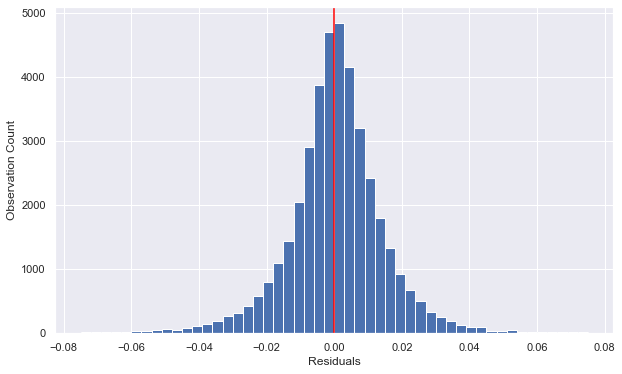

In [32]:
residuals.hist(bins=50,range=(-.075,.075),figsize=(10,6))
plt.axvline(x=0,color="red")
plt.xlabel("Residuals")
plt.ylabel("Observation Count")

In [33]:
def calc_signal(model,fac,dict_train,dict_test,dict_backtest,tickerlist=tickerlist):
    """
    dict_test: dict of dataframes for each ticker containing factors and ForwardReturns
    """
    train_signals = {}
    test_signals = {}
    backtest_signals = {}
    for ticker in tickerlist:
        df_train = dict_train[ticker].copy()
        df_test = dict_test[ticker].copy()
        df_backtest = dict_backtest[ticker].copy()
        train_signals[ticker] = model.predict(df_train[fac])
        test_signals[ticker] = model.predict(df_test[fac])
        backtest_signals[ticker] = model.predict(df_backtest[fac])
    train_signals = pd.DataFrame(train_signals,index=df_train.index)
    test_signals = pd.DataFrame(test_signals,index=df_test.index)
    backtest_signals = pd.DataFrame(backtest_signals,index=df_backtest.index)
    return train_signals,test_signals,backtest_signals

train_signals,test_signals,backtest_signals = calc_signal(model,
                                                          finalFactors,train,test,backtest,tickerlist)

### Risk Model and Transaction Model

In [34]:
def compileWeight(all_data,backtest_signals,tickerlist,scale):
    close = {}
    annVol = {}
    cost = {}
    signal = {}
    for ticker in tickerlist:
        temp = all_data[ticker][["Close","Volume"]].copy()
        temp["Returns"] = temp.Close.pct_change()
        temp["MDV21"] = temp.Volume.rolling(21).median()
        temp["AnnVol"] = temp.Returns.rolling(252).std()*np.sqrt(252)*100
        temp["Cost"] = 0.004*temp.AnnVol/temp.MDV21
        temp["Signal"] = backtest_signals[ticker]
        temp = temp[["Close","AnnVol","Cost","Signal"]]["2018":"2020"]
        close[ticker] = temp.Close
        annVol[ticker] = temp.AnnVol
        cost[ticker] = temp.Cost
        signal[ticker] = temp.Signal
    close = pd.DataFrame(close)
    annVol = pd.DataFrame(annVol)
    annVol = annVol**(-scale)
    annVol = annVol.div(annVol.sum(axis=1),axis=0)
    cost = pd.DataFrame(cost)
    costWeight = cost**(-scale)
    costWeight = costWeight.div(costWeight.sum(axis=1),axis=0)
    signal = pd.DataFrame(signal)
    signal = np.abs(signal)**(scale)
    signal = signal.div(signal.sum(axis=1),axis=0)
    return close,annVol,cost,costWeight,signal

In [35]:
scale = 2
close,annVolWeight,costs,costWeight,signalWeight = compileWeight(all_data,backtest_signals,tickerlist,scale)
unweighted = pd.DataFrame([[1/costWeight.shape[1]]*costWeight.shape[1]]*costWeight.shape[0],
             index=costWeight.index,columns=costWeight.columns)
_,_,_,_,sigWeight2 = compileWeight(all_data,backtest_signals,tickerlist,10)

## Backtest

In [36]:
def weightedTrader(initial_value,signals,weights,close=close,costs=costs):
    signals = np.sign(backtest_signals)
    rets = close.pct_change()

    portfolioValue = [initial_value]
    positions = [signals.iloc[0]*weights.iloc[0]*portfolioValue[0]] # dollars invested in each stock
    transactionCosts = [(positions[0].abs()*costs.iloc[0]).sum()] # dollar amount of transaction cost
    weightedReturns = [[0]*len(tickerlist)]
    portfolioRet = [0]
    
    for i in range(1,len(signals)):
        portReturn = ((rets.iloc[i]*positions[i-1]).sum()-transactionCosts[i-1])/portfolioValue[i-1]
        portfolioRet.append(portReturn)
        portfolioValue.append(portfolioValue[i-1]*(1+portReturn)) # new total portfolio value after subtracting trading costs
        positions.append(signals.iloc[i]*weights.iloc[i]*portfolioValue[i]) # reweighted positions
        positionChange = (positions[i]-positions[i-1]).abs() # dollar change in position for each stock
        transactionCosts.append((positionChange*costs.iloc[i]).sum()) # calc transaction cost to achieve new position
    df = pd.DataFrame({"PortfolioValue":portfolioValue,"TransactionCosts":transactionCosts,
                   "PortfolioReturns":portfolioRet},index=close.index[:-1])
    positions = pd.DataFrame(positions)
    return df,df.PortfolioValue,positions

In [37]:
initial_value = 100000000 # $100,000,000 million
_,unweightedValue,_ = weightedTrader(initial_value,backtest_signals,unweighted)
_,signalValue,pos = weightedTrader(initial_value,backtest_signals,signalWeight)
_,annVolValue,_ = weightedTrader(initial_value,backtest_signals,annVolWeight)
_,costValue,pos = weightedTrader(initial_value,backtest_signals,costWeight)

In [38]:
NDX = yf.download("^NDX")["Adj Close"].loc[backtest_signals.index]
NDX = NDX*initial_value/NDX[0]
df = pd.DataFrame({"UnweightedStrategy":unweightedValue,"SignalWeightedStrategy":signalValue,
                   "VolatilityWeightedStrategy":annVolValue,"CostWeightedStrategy":costValue,"NDX":NDX})

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Portfolio Value')

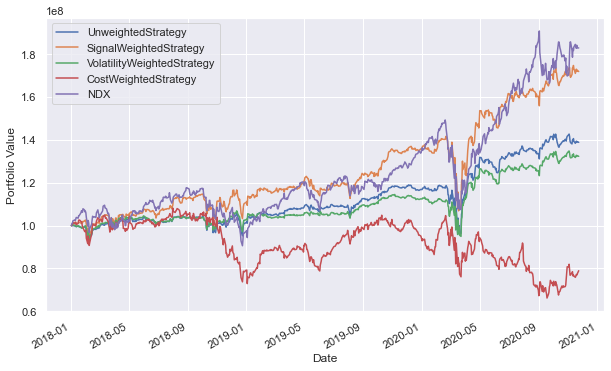

In [39]:
df.plot(figsize=(10,6))
plt.ylabel("Portfolio Value")

Text(0, 0.5, 'Portfolio Value')

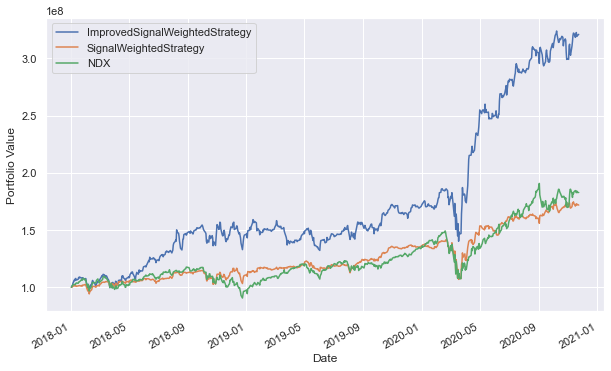

In [40]:
_,_,_,_,sigWeight2 = compileWeight(all_data,backtest_signals,tickerlist,10)
_,sig2,_ = weightedTrader(initial_value,backtest_signals,sigWeight2)
NDX = NDX*initial_value/NDX[0]
df2 = pd.DataFrame({"ImprovedSignalWeightedStrategy":sig2,"SignalWeightedStrategy":signalValue,"NDX":NDX})
df2.plot(figsize=(10,6))
plt.ylabel("Portfolio Value")

In [41]:
df = pd.DataFrame({"UnweightedStrategy":unweightedValue,"SignalWeightedStrategy":signalValue,
                   "VolatilityWeightedStrategy":annVolValue,
                   "ImprovedSignalWeightedStrategy":sig2,"NDX":NDX})
R = df.pct_change()

### Performance Metrics

In [42]:
all_ratios = []
for strat in R.columns:
    ratios = []
    r = R[strat].dropna()
    ratios.append(ep.annual_return(r))
    ratios.append(ep.annual_volatility(r))
    ratios.append(ep.max_drawdown(r))
    ratios.append(ep.sharpe_ratio(r))
    ratios.append(ep.sortino_ratio(r))
    all_ratios.append(ratios)

In [43]:
metrics =pd.DataFrame(all_ratios,columns=["Annualized Return","Annualized Volatility",
                                         "Max Drawdown","Sharpe Ratio","Sortino Ratio"],index=R.columns)
metrics

,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio
UnweightedStrategy,0.120028,0.186161,-0.189854,0.701994,1.054687
SignalWeightedStrategy,0.205782,0.234772,-0.245483,0.914855,1.356375
VolatilityWeightedStrategy,0.101557,0.170904,-0.170633,0.651197,0.999119
ImprovedSignalWeightedStrategy,0.496557,0.304763,-0.246314,1.475781,2.274069
NDX,0.231970,0.268839,-0.280329,0.911354,1.270724
